In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax,blackjax
jax.config.update("jax_enable_x64", True)
#sys.path.append('../synax/')

import synax,importlib
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

In [12]:
#for debug
def reload_package(package):
    importlib.reload(package)
    for attribute_name in dir(package):
        attribute = getattr(package, attribute_name)
        if type(attribute) == type(package):
            importlib.reload(attribute)
            
reload_package(synax)

2024-07-25 14:37:45.342423: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(3, 49152, 512)

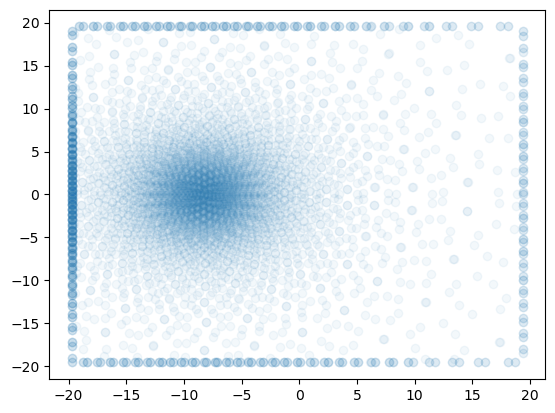

In [3]:
nside = 64
num_int_points = 512
#obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=num_int_points))
#n_pixs = np.arange(0,12*nside**2)
#theta,phi = hp.pix2ang(nside,n_pixs)
poss,dls,nhats = synax.coords.get_healpix_positions(nside=nside,num_int_points=num_int_points)
plt.scatter(poss[0,::10,500],poss[1,::10,500],alpha=0.05)
poss.shape

In [4]:
C_generator = synax.cfield.C_WMAP(poss)

C_field = C_generator.C_field()

In [5]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

In [6]:
dtype = np.float64
#tereg = np.fromfile('../../SyncEmiss/tereg.bin', dtype=dtype).reshape((256,256,64))#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))
#np.save('te.npy',tereg)
tereg = np.load('te.npy')

In [8]:
TE_generator = synax.tefield.TE_grid(poss,(xs,ys,zs))
TE_field = TE_generator.TE_field(tereg)

In [13]:
nx,ny,nz = 128,128,32

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

B_generator = synax.bfield.B_grid(poss,(xs,ys,zs))
B_field = jnp.ones((nx,ny,nz,3))*1e-6
B_generator.B_field(B_field).shape

(49152, 512, 3)

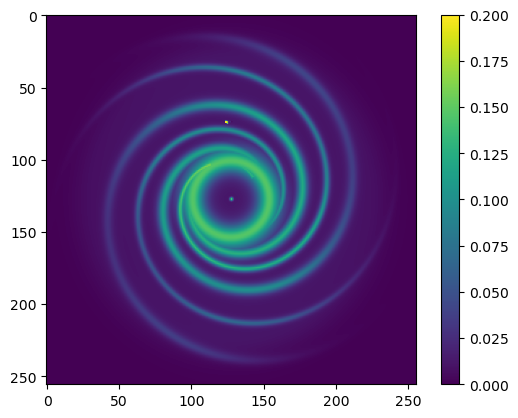

In [14]:
plt.imshow(tereg[:,:,32],vmax=0.2)
plt.colorbar()

## read observation and add noise

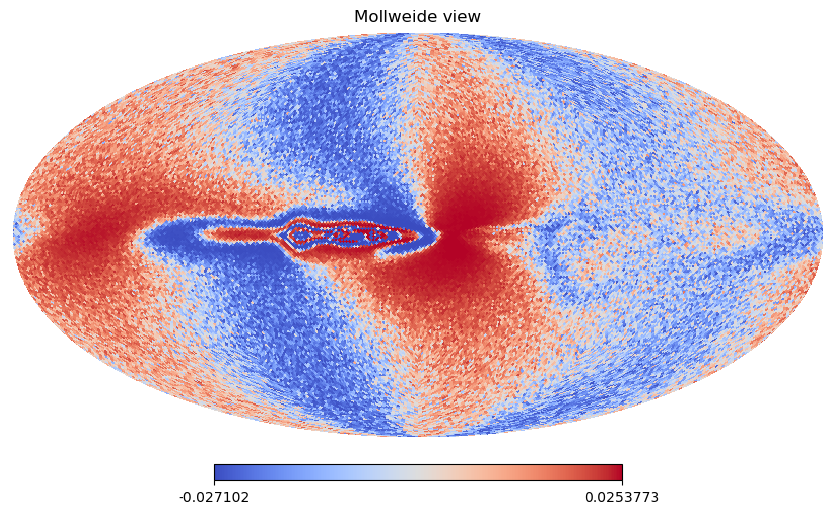

In [15]:
obs_maps = np.load('Sim_lsa.npy')
np.random.seed(42)
obs_Q = obs_maps[0] + np.random.randn(obs_maps[0].shape[0])*0.001
obs_U = obs_maps[1] + np.random.randn(obs_maps[0].shape[0])*0.001


hp.mollview(obs_Q,norm='hist',cmap='coolwarm')

In [16]:
from datetime import date
rng_key = jax.random.key(42)
simer = synax.synax.Synax(sim_I = False)
freq = 2.4
spectral_index = 3.

In [19]:
@jax.jit
def grid_model(B_field_grid,freq):

    B_field = B_generator.B_field(B_field_grid)
    
    sync = simer.sim(freq,B_field,C_field,TE_field,nhats,dls,spectral_index)
    
    return sync['Q'],sync['U']


freq = 2.4

def logdensity_fn(B_field):
    
    Sync_Q,Sync_U = grid_model(B_field,freq)

    return -1*jnp.sum(((Sync_Q-obs_Q)/0.001/2)**2) - jnp.sum(((Sync_U-obs_U)/0.001/2)**2)

#B_generator = bfield.B_lsa(coords)
#B_field = B_generator.B_field(lsa_params).reshape((nx,ny,nz,3))
B_field = (np.random.randn(nx,ny,nz,3)*1e-7)*jnp.array([1.,1.,0.1])
Sync_Q,Sync_U = grid_model(B_field,freq)

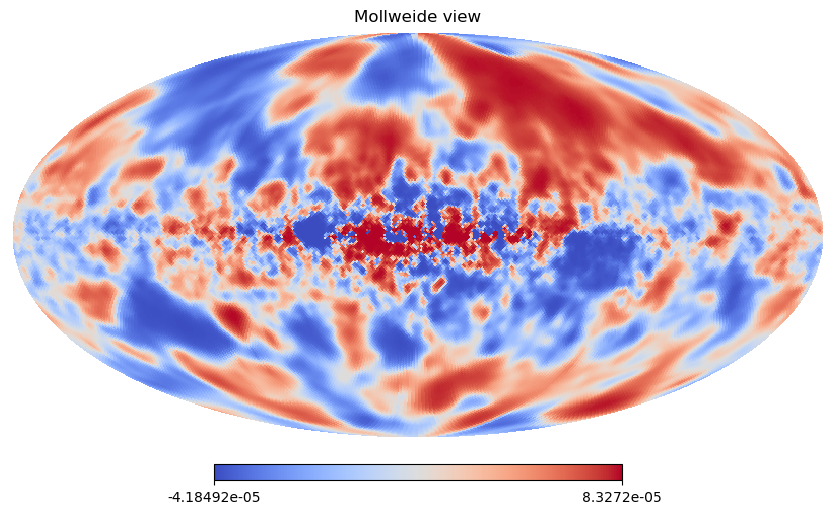

In [22]:
hp.mollview(Sync_U,norm='hist',cmap='coolwarm')

In [23]:
logp_grad = jax.value_and_grad(lambda x:-1*logdensity_fn(x))

In [24]:
import optax
from tqdm import tqdm

B_field = (np.random.randn(*(nx,ny,nz,3))*1e-7)*jnp.array([1.,1.,0.1])
#B_generator = bfield.B_lsa(coords)
#B_field = B_generator.B_field(lsa_params).reshape((nx,ny,nz,3))
B_opt = B_field
#solver = optax.yogi(1e-8)
solver = optax.yogi(learning_rate=1e-7)

opt_state = solver.init(B_opt)

loss = []

ones_field = np.ones((nx,ny,nz))

mask = ((coords[0]**2+coords[1]**2)>400)|((coords[0]**2+coords[1]**2)<9)

ones_field[mask] = 1e-10

mask = jnp.array(ones_field)[:,:,:,jnp.newaxis]
#mask = C_field/C_field.max()
B_opt = B_opt*mask

progress_bar = tqdm(range(200))
for i in progress_bar:
    value,grad = logp_grad(B_opt)
    if jnp.isnan(value):
        break
    #grad.at[jnp.abs(grad)>1e-6].set(1e-6)
    #grad = jnp.nan_to_num(grad, nan=1e-6)
    loss.append(value)
    updates, opt_state = solver.update(grad, opt_state, B_opt)
    B_opt = optax.apply_updates(B_opt, updates)
    B_opt = B_opt*mask
    #B_opt = jnp.where(B_opt > 1e-5, 1e-5, B_opt)
    info = { 'loss': loss[-1]}
    
    # Update the postfix with the current info
    progress_bar.set_postfix(info)

100%|██████████| 200/200 [01:29<00:00,  2.24it/s, loss=10323.34598847161] 


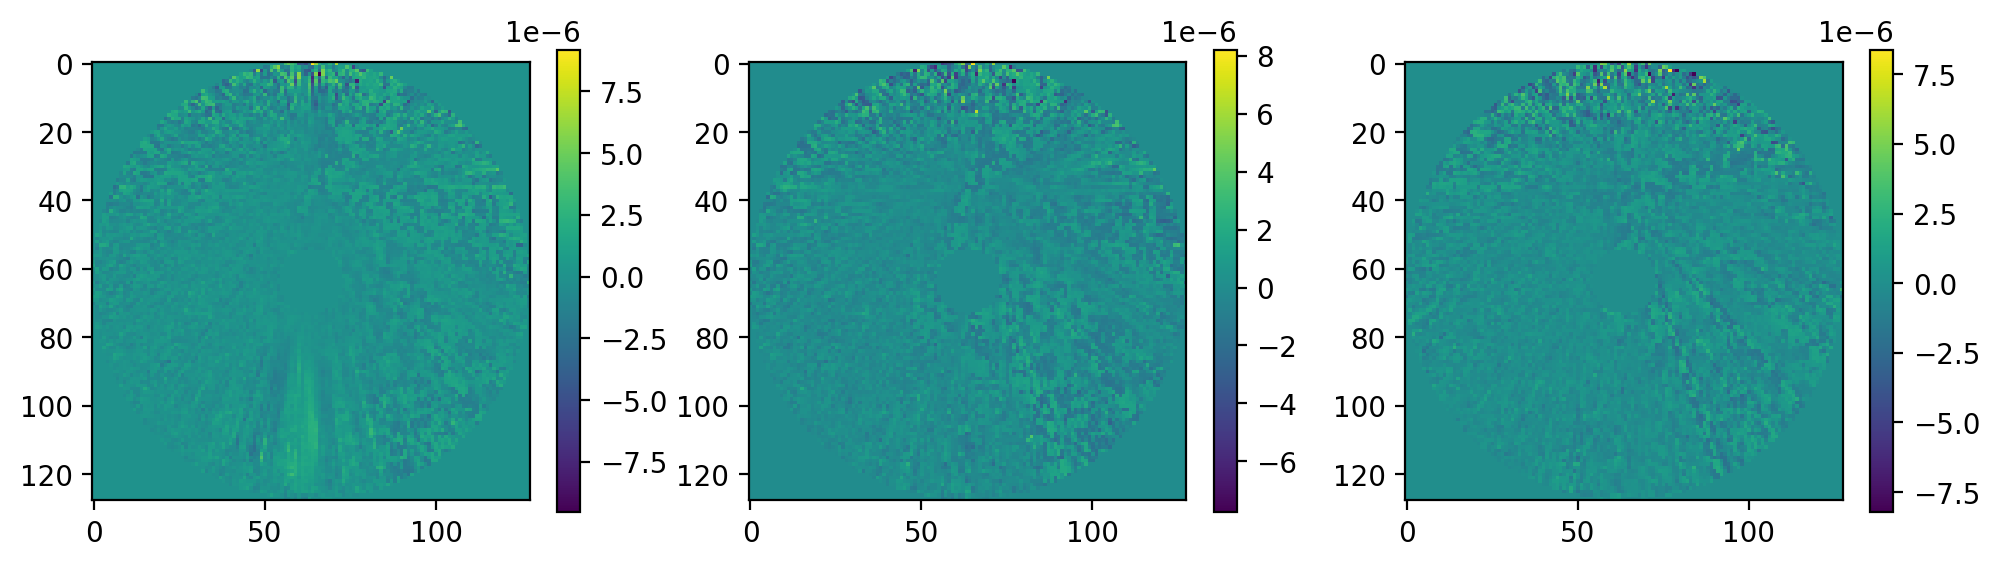

In [25]:
plt.figure(dpi=200,figsize=(12,3))

plt.subplot(131)
plt.imshow(B_opt[:,:,16,0])
plt.colorbar()

plt.subplot(132)
plt.imshow(B_opt[:,:,16,1])
plt.colorbar()

plt.subplot(133)
plt.imshow(B_opt[:,:,16,2])
plt.colorbar()

In [26]:
Sync_Q_int,Sync_U_int = grid_model(B_opt,freq)

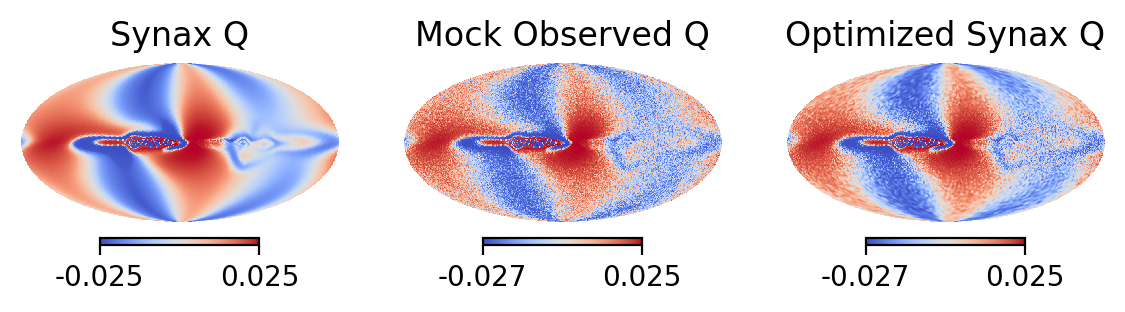

In [28]:
plt.figure(dpi=200,figsize=(7,2),)
np.random.seed(42)
plt.subplot(131)
hp.mollview(obs_maps[0],format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Synax Q')

plt.subplot(132)
hp.mollview(obs_Q,format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Mock Observed Q')

plt.subplot(133)
hp.mollview(Sync_Q_int,format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Optimized Synax Q')

#plt.savefig("../figures/lsa_opt.pdf",bbox_inches='tight',dpi=200)

Text(0.5, 1.0, 'Residuals')

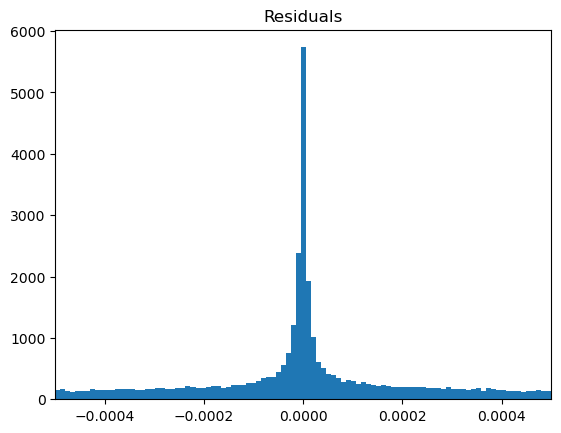

In [33]:
plt.hist(Sync_Q_int-obs_Q,bins=np.linspace(-0.0005,0.0005,100))
plt.xlim((-0.0005,0.0005))
plt.title('Residuals')

In [34]:
lsa_params = {"b0":1.2,
               "psi0":27.0*np.pi/180,
               "psi1":0.9*np.pi/180,
               "chi0":25.0*np.pi/180}

B_generator = synax.bfield.B_lsa(coords)
B_true = B_generator.B_field(lsa_params)

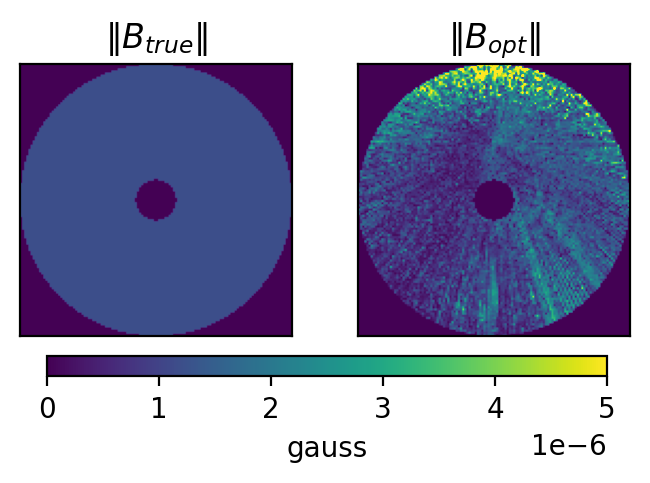

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2),dpi=200)

# Plot the first subplot
im1 = axs[0].imshow(((B_true**2).sum(axis=-1)**(1/2))[:,:,16], vmax=5e-6, vmin=0)
axs[0].set_title(r'$\Vert B_{true} \Vert$')

axs[0].set_xticks([])  # Turn off x ticks
axs[0].set_yticks([])

# Plot the second subplot
im2 = axs[1].imshow(((B_opt**2).sum(axis=-1)**(1/2))[:,:,16], vmax=5e-6, vmin=0)
axs[1].set_title(r'$\Vert B_{opt} \Vert$')

axs[1].set_xticks([])  # Turn off x ticks
axs[1].set_yticks([])

# Add the colorbar
fig.subplots_adjust(bottom=0.2)  # Make space for the colorbar
cbar_ax = fig.add_axes([0.165, 0.1, 0.7, 0.05])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('gauss')

#plt.savefig('../figures/opt_B.pdf',dpi=500)